# Lab 3 Part 2: Batch Normalization 



------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of Lab 3. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [65]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
mnist_trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

# Download and load the test data
mnist_testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [66]:
class MLP(nn.Module):

    def __init__(self, dimx, hidden1, hidden2, nlabels, use_batch_norm):  # Nlabels will be 10 in our case
        super().__init__()
        # Keep track of whether or not this network uses batch normalization.
        self.dimx = dimx
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = x.view(-1, self.dimx)
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.logsoftmax(self.output3(x)) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [67]:
import copy

def create_validation_set(trainloader, size=0.8):
    validloader = copy.deepcopy(trainloader)
    pctg = int(len(trainloader.dataset.data) * size)

    trainloader.dataset.data = trainloader.dataset.data[:pctg,:,:]
    trainloader.dataset.targets = trainloader.dataset.targets[:pctg]
    #And the rest for validation
    validloader.dataset.data = validloader.dataset.data[pctg:,:,:]
    validloader.dataset.targets = validloader.dataset.targets[pctg:]

    return trainloader, validloader

mnist_trainloader, mnist_validloader = create_validation_set(mnist_trainloader)

print(mnist_trainloader.dataset.data.shape)
print(mnist_validloader.dataset.data.shape)

torch.Size([48000, 28, 28])
torch.Size([12000, 28, 28])


In [68]:
class ExtendedMLP(MLP):

    def __init__(self, epochs=100, lr=0.001, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.lr = lr  # Learning Rate
        self.epochs = epochs

        self.optim = optim.Adam(self.parameters(), self.lr)        
        self.criterion = nn.NLLLoss()
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
    def trainloop(self, trainloader, validloader, print_every=10):
        # Optimization Loop
        for e in range(int(self.epochs)):
            # Random data permutation at each epoch
            running_loss, val_running_loss = 0.0, 0.0
            self.train()
            for images, labels in trainloader:
                # Move input and label tensors to the default device                
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)

                running_loss += loss.item()
                loss.backward()
                self.optim.step()  
            
            with torch.no_grad():
                for images, labels in validloader:
                    val_out = self.forward(images)
                    val_loss = self.criterion(val_out, labels)
                    val_running_loss += val_loss.item()
                    
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(val_running_loss/len(validloader))

            if print_every == -1:
                pass
            elif (e % print_every == 0): # Every 10 epochs
                print(f"Epoch {e+1}. Training loss: {self.loss_during_training[-1]}\n \
                        Validation loss: {self.valid_loss_during_training[-1]}\n")
    
    def evaluate(self, dataloader):
        # Turn off gradients for validation, saves memory and computations
        self.eval()
        with torch.no_grad():
            loss, accuracy = 0, 0
            for images, labels in dataloader:

                probs = self.forward(images)

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        self.train()
        return accuracy/len(dataloader)


### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

In [69]:
epochs = 10

net_batchnorm = ExtendedMLP(dimx=28*28, hidden1=2**8, hidden2=2**7,
                            use_batch_norm=True,
                            nlabels=10, epochs=epochs, lr=0.001)

net_no_norm = ExtendedMLP(dimx=28*28, hidden1=2**8, hidden2=2**7,
                          use_batch_norm=False,
                          nlabels=10, epochs=epochs, lr=0.001)

net_batchnorm.trainloop(mnist_trainloader, mnist_validloader)
net_no_norm.trainloop(mnist_trainloader, mnist_validloader)

Epoch 1. Training loss: 0.22740369470417499
                         Validation loss: 0.12006685232862513

Epoch 1. Training loss: 0.37851290006935595
                         Validation loss: 0.2086020739392397



In [70]:
batch_train_acc = net_batchnorm.evaluate(mnist_trainloader)
batch_valid_acc = net_batchnorm.evaluate(mnist_validloader)

print(f"Train Accuracy with BN: {batch_train_acc}")
print(f"Validation Accuracy with BN: {batch_valid_acc}\n")

no_batch_train_acc = net_no_norm.evaluate(mnist_validloader)
no_batch_valid_acc = net_no_norm.evaluate(mnist_validloader)

print(f"Train Accuracy without BN: {no_batch_train_acc}")
print(f"Validation Accuracy without BN: {no_batch_valid_acc}\n")

Train Accuracy with BN: 0.9975833296775818
Validation Accuracy with BN: 0.9806349873542786

Train Accuracy without BN: 0.9719082713127136
Validation Accuracy without BN: 0.9717420339584351



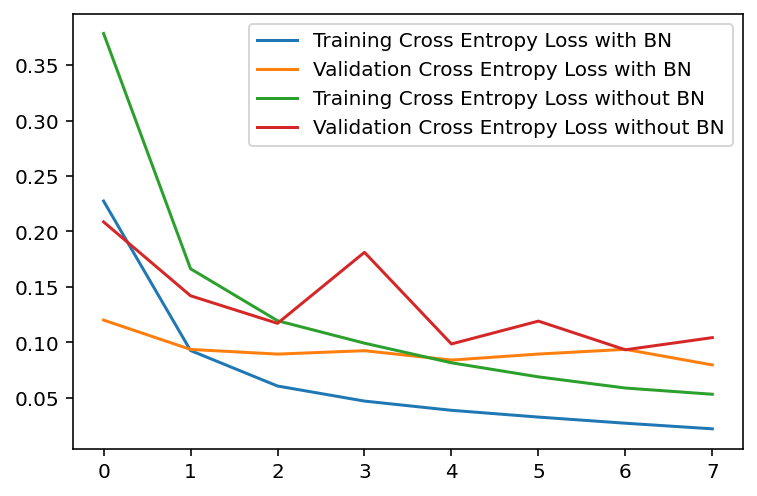

In [71]:
# NN with Batch-Normalization
plt.plot(range(epochs),
         net_batchnorm.loss_during_training,
         label='Training Cross Entropy Loss with BN')

plt.plot(range(epochs),
         net_batchnorm.valid_loss_during_training,
         label='Validation Cross Entropy Loss with BN')

# NN without Batch-Normalization
plt.plot(range(epochs),
         net_no_norm.loss_during_training,
         label='Training Cross Entropy Loss without BN')

plt.plot(range(epochs),
         net_no_norm.valid_loss_during_training,
         label='Validation Cross Entropy Loss without BN')
plt.legend()
plt.show()

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Using CIFAR10 database, incorporate BN to your solution of Lab 3 (Part I). Compare the results with and without BN!!

In [72]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

cifar_testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [73]:
print(cifar_trainloader.dataset.data.shape)
cifar_trainloader, cifar_validloader = create_validation_set(cifar_trainloader)

print(cifar_trainloader.dataset.data.shape)
print(cifar_validloader.dataset.data.shape)

(50000, 32, 32, 3)
(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [74]:
class BatchCNN(nn.Module):

    def __init__(self, dimx, epochs, lr, nlabels, use_batch_norm): #Nlabels will be 10 in our case
        super().__init__()
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(16*5*5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, nlabels)
        
        self.relu = nn.ReLU()  # Relu activation function
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(120)
            self.batch_norm2 = nn.BatchNorm1d(84)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        self.lr = lr  # Learning Rate
        self.epochs = epochs

        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.NLLLoss()
        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2) 
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x) 
        x = self.linear2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.logsoftmax(self.linear3(x))
        return x

    def trainloop(self, trainloader, validloader, print_every = 5):
        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            # Random data permutation at each epoch
            running_loss = 0.
            val_running_loss = 0.
            self.train()
            for images, labels in trainloader:
                self.optim.zero_grad()  # TO RESET GRADIENTS!
                out = self.forward(images)
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                loss.backward()
                self.optim.step()  

            with torch.no_grad():
                for images, labels in validloader:
                    val_out = self.forward(images)
                    val_loss = self.criterion(val_out,labels)
                    val_running_loss += val_loss.item()

            self.loss_during_training.append(running_loss/len(trainloader))    
            self.valid_loss_during_training.append(val_running_loss/len(validloader))

            if print_every == -1:
                pass
            elif (e % print_every == 0):
                print(f"Epoch {e+1}. Training loss: {self.loss_during_training[-1]},\n \
                        Validation loss: {self.valid_loss_during_training[-1]},\n \
                        Time per epoch: {time.time() - start_time} seconds\n")
    
    def evaluate(self, dataloader):
        # Turn off gradients for validation, saves memory and computations
        self.eval()
        with torch.no_grad():
            loss, accuracy = 0, 0
            for images, labels in dataloader:
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        self.train()
        return accuracy/len(dataloader)


In [75]:
epochs = 20

my_batch_CNN = BatchCNN(dimx=32, nlabels=10,
                        use_batch_norm=True,
                        epochs=epochs, lr=0.001)
my_batch_CNN.trainloop(cifar_trainloader, cifar_validloader)

Epoch 1. Training loss: 1.4598736177444458,
                         Validation loss: 1.288172702880422,
                         Time per epoch: 20.067341089248657 seconds

Epoch 6. Training loss: 0.8354579717636108,
                         Validation loss: 1.0441328063132658,
                         Time per epoch: 20.331775188446045 seconds

Epoch 11. Training loss: 0.634923169183731,
                         Validation loss: 1.0832212088973658,
                         Time per epoch: 20.26401996612549 seconds

Epoch 16. Training loss: 0.5028400164842606,
                         Validation loss: 1.2080214183042004,
                         Time per epoch: 20.471912622451782 seconds



In [76]:
print(f"Train Accuracy with BN: {my_batch_CNN.evaluate(cifar_trainloader)}")
print(f"Validation Accuracy with BN: {my_batch_CNN.evaluate(cifar_validloader)}\n")

Train Accuracy with BN: 0.8970249891281128
Validation Accuracy with BN: 0.6396297812461853



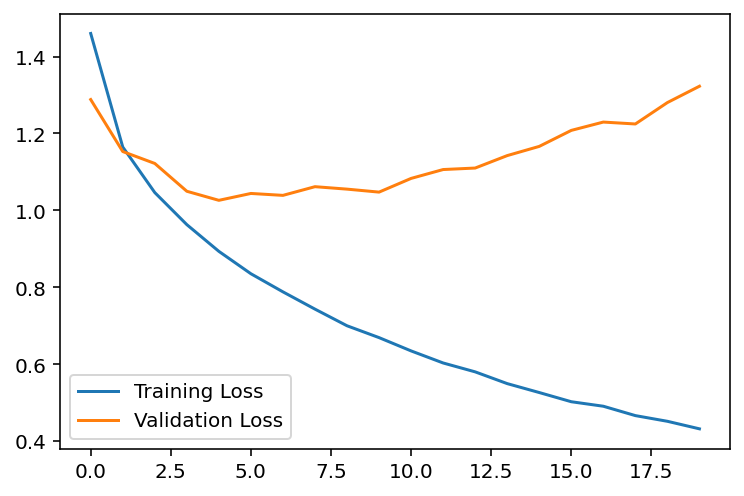

In [77]:
plt.plot(range(epochs),
         my_batch_CNN.loss_during_training,
         label='Training Loss')

plt.plot(range(epochs),
         my_batch_CNN.valid_loss_during_training,
         label='Validation Loss')

plt.legend()
plt.show()